In [1]:
from SciServer import Authentication, CasJobs, SciDrive, SkyServer

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_colwidth', None)
%matplotlib widget

loginName = ""
loginPassword = r''

In [ ]:
token = Authentication.login(loginName, loginPassword)
user = Authentication.getKeystoneUserWithToken(token)
print("userName=" + user.userName)
print("id=" + user.id)

In [ ]:
query = """
SELECT p.objId, p.ra, p.dec, p.petror90_r as brightness,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i,
    s.z, z.spiral, z.elliptical, z.uncertain
FROM galaxy AS p
    JOIN SpecObj AS s ON s.bestobjid = p.objid
    JOIN zooSpec AS z ON z.objid = p.objid
WHERE p.ra between 100 and 250
    AND s.z between 0.02 and 0.5
    AND NOT z.uncertain = 1;
"""
all_gals = CasJobs.executeQuery(query, "dr8", format="pandas")
print(f"SQL query returned {len(all_gals)} galaxies.")

In [ ]:
all_gals.to_pickle("all_gals.pkl")

In [2]:
all_gals = pd.read_pickle("all_gals.pkl")

In [ ]:
all_gals.head()

In [ ]:
all_gals.dtypes

In [3]:
slice1 = all_gals[(all_gals["z"] > 0.02) & (all_gals["z"] < 0.04)]
print(f"Size of slice 1: {len(slice1)}")

Size of slice 1: 19964


In [4]:
ellipticals = slice1[slice1["elliptical"] == 1]
spirals = slice1[slice1["spiral"] == 1]
print(f"Ellipticals: {len(ellipticals)}")
print(f"Spirals: {len(spirals)}")

Ellipticals: 4444
Spirals: 15520


In [ ]:
ellipticals.head()

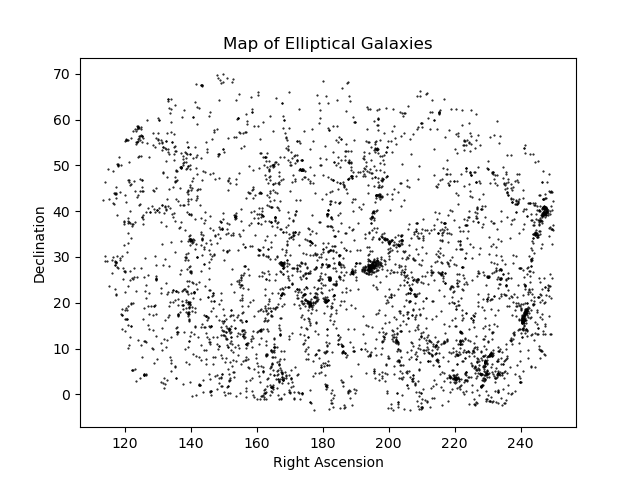

In [5]:
plt.figure(1)
plt.scatter(ellipticals["ra"], ellipticals["dec"], marker=".", s=1, c="black")
plt.title("Map of Elliptical Galaxies")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.show()

Estimated number of clusters: 7
Estimated number of noise points: 3868


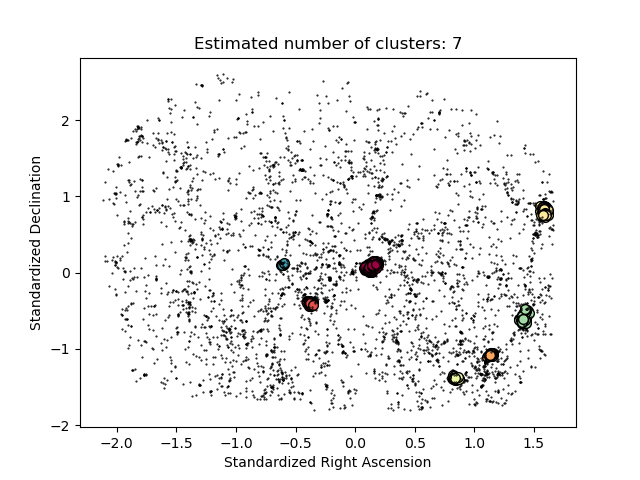

In [6]:
X = StandardScaler().fit_transform(ellipticals[["ra", "dec"]])
db = DBSCAN(eps=0.05, min_samples=30).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

ellipticals.insert(len(ellipticals.columns)-3, "cluster", labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters:", n_clusters_)
print("Estimated number of noise points:", n_noise_)

plt.figure(2)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], ".", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=1)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.xlabel("Standardized Right Ascension")
plt.ylabel("Standardized Declination")
plt.show()

Text(0, 0.5, 'Declination')

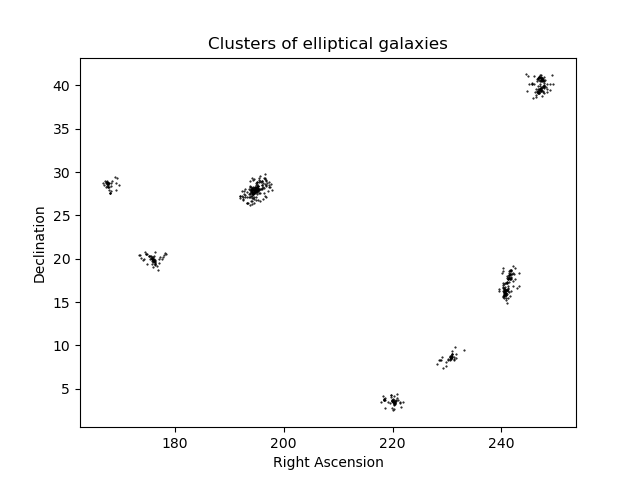

In [7]:
clustered_ellipticals = ellipticals[ellipticals["cluster"] > -1]
plt.figure(3)
plt.scatter(clustered_ellipticals["ra"], clustered_ellipticals["dec"], marker=".", s=1, c="black")
plt.title("Clusters of elliptical galaxies")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

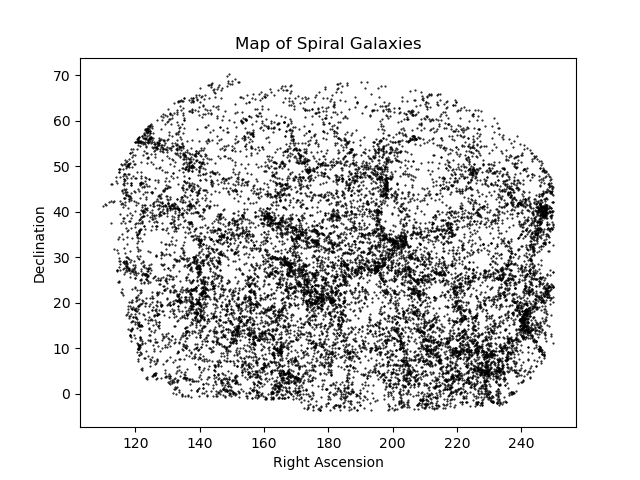

In [8]:
plt.figure(4)
plt.scatter(spirals["ra"], spirals["dec"], marker=".", s=1, c="black")
plt.title("Map of Spiral Galaxies")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.show()

Estimated number of clusters: 9
Estimated number of noise points: 14550


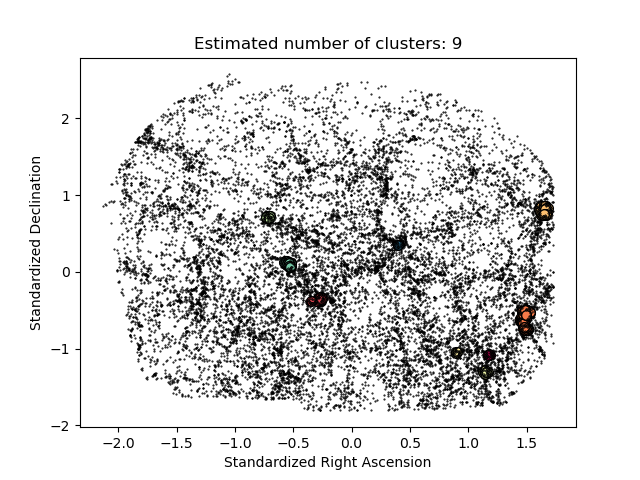

In [9]:
X = StandardScaler().fit_transform(spirals[["ra", "dec"]])
db = DBSCAN(eps=0.05, min_samples=50).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

spirals.insert(len(spirals.columns)-3, "cluster", labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters:", n_clusters_)
print("Estimated number of noise points:", n_noise_)

plt.figure(5)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], ".", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=1)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.xlabel("Standardized Right Ascension")
plt.ylabel("Standardized Declination")
plt.show()

Text(0, 0.5, 'Declination')

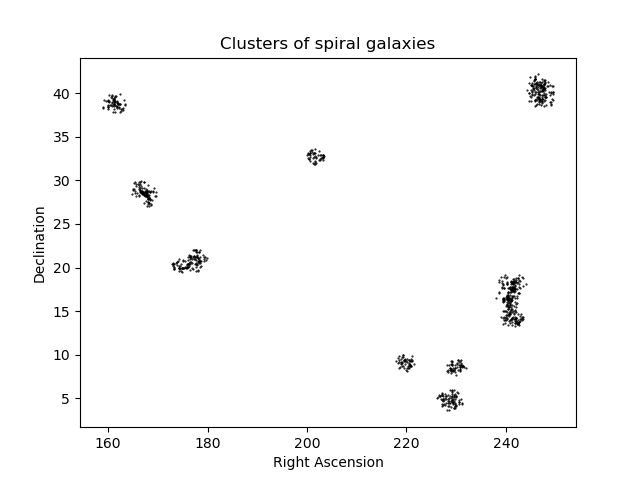

In [10]:
clustered_spirals = spirals[spirals["cluster"] > -1]
plt.figure(6)
plt.scatter(clustered_spirals["ra"], clustered_spirals["dec"], marker=".", s=1, c="black")
plt.title("Clusters of spiral galaxies")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

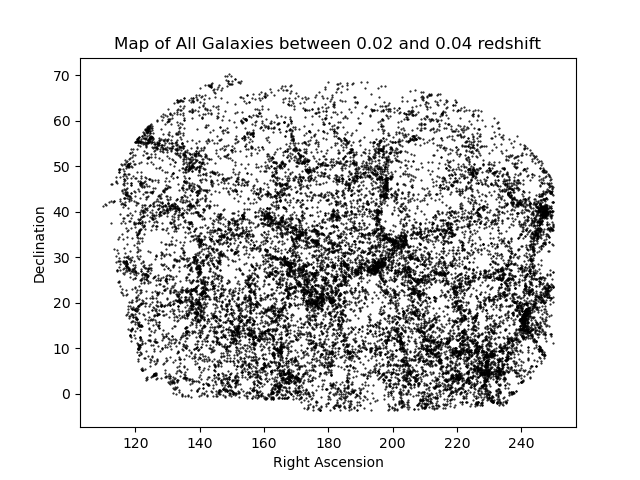

In [11]:
plt.figure(7)
plt.scatter(slice1["ra"], slice1["dec"], marker=".", s=1, c="black")
plt.title("Map of All Galaxies between 0.02 and 0.04 redshift")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.show()

Estimated number of clusters: 20
Estimated number of noise points: 16754


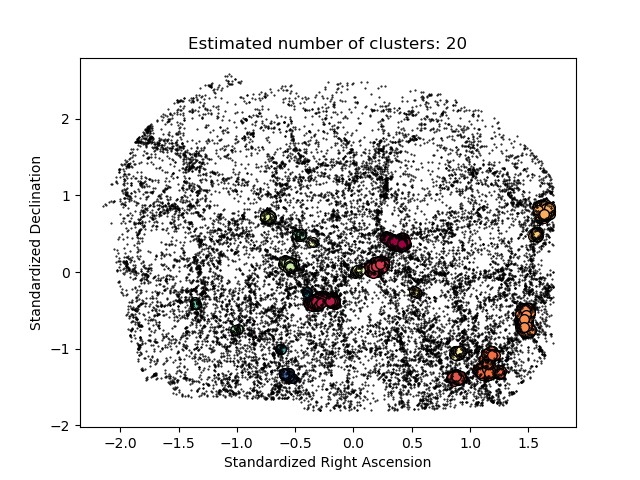

In [12]:
X = StandardScaler().fit_transform(slice1[["ra", "dec"]])
db = DBSCAN(eps=0.05, min_samples=50).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

slice1.insert(len(slice1.columns)-3, "cluster", labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters:", n_clusters_)
print("Estimated number of noise points:", n_noise_)

plt.figure(8)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], ".", markerfacecolor=tuple(col),
             markeredgecolor="k", markersize=1)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.xlabel("Standardized Right Ascension")
plt.ylabel("Standardized Declination")
plt.show()

Text(0, 0.5, 'Declination')

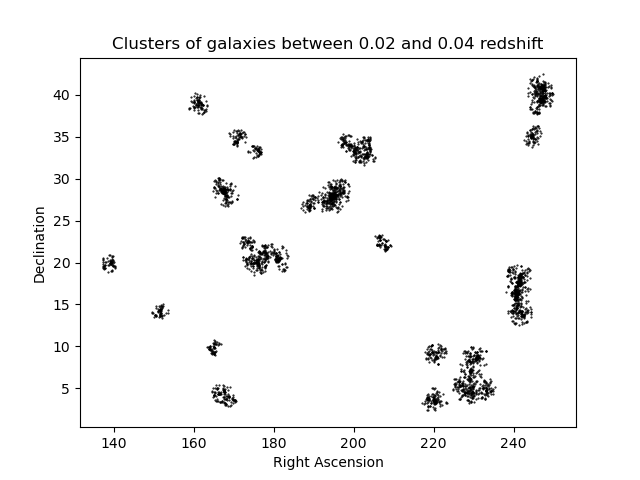

In [13]:
clustered_slice1 = slice1[slice1["cluster"] > -1]
plt.figure(9)
plt.scatter(clustered_slice1["ra"], clustered_slice1["dec"], marker=".", s=1, c="black")
plt.title("Clusters of galaxies between 0.02 and 0.04 redshift")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

Text(0, 0.5, 'Declination')

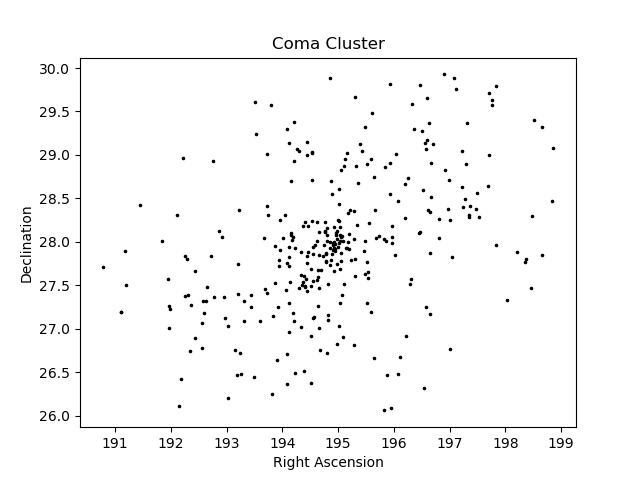

In [14]:
coma_cluster = clustered_slice1[clustered_slice1["cluster"] == 2]
plt.figure(10)
plt.scatter(coma_cluster["ra"], coma_cluster["dec"], marker=".", s=10, c="black")
plt.title("Coma Cluster")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

In [15]:
num_ellipticals_in_clusters = len(clustered_slice1[clustered_slice1["elliptical"] == 1])
num_spirals_in_clusters = len(clustered_slice1[clustered_slice1["spiral"] == 1])
num_galaxies_in_clusters = len(clustered_slice1)
print(f"Number of ellipticals in clusters: {num_ellipticals_in_clusters}")
print(f"Number of spirals in clusters: {num_spirals_in_clusters}")
print(f"Number of galaxies in clusters: {num_galaxies_in_clusters}")

Number of ellipticals in clusters: 1064
Number of spirals in clusters: 2146
Number of galaxies in clusters: 3210


In [16]:
null_prop = len(ellipticals) / len(slice1)
stat, pval = proportions_ztest(count=num_ellipticals_in_clusters, 
                               nobs=num_galaxies_in_clusters,
                               value=null_prop)
print(f"prop of elliptical galaxies: {null_prop}")
print(f"prop of elliptical galaxies in clusters: {num_ellipticals_in_clusters/num_galaxies_in_clusters}")
print(f"p-value: {pval}")

prop of elliptical galaxies: 0.2226006812262072
prop of elliptical galaxies in clusters: 0.3314641744548287
p-value: 3.1859140484428565e-39


Clusters seem to have more elliptical galaxies than spiral galaxies

Text(0, 0.5, 'Prop of Ellipticals')

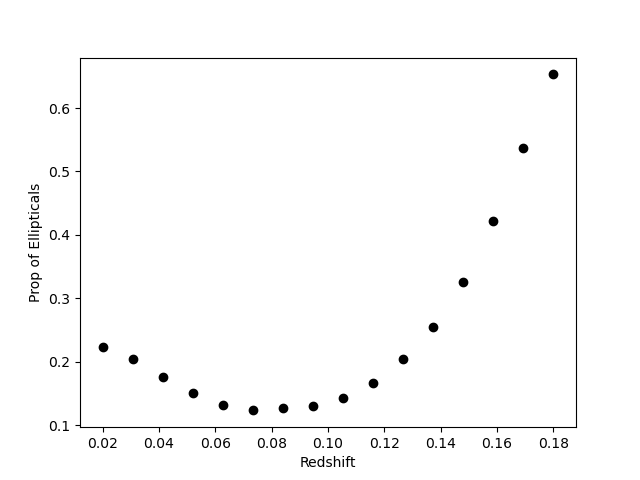

In [26]:
prop_of_ellips = []
redshifts = np.linspace(0.02, 0.18, 16)
for z in redshifts:
    z_slice = all_gals[all_gals["z"] > z]
    z_slice = z_slice[z_slice["z"] < z+0.02]
    prop = len(z_slice[z_slice["elliptical"] == 1]) / len(z_slice)
    prop_of_ellips.append(prop)
plt.figure(11)
plt.scatter(redshifts, prop_of_ellips, c="black")
plt.xlabel("Redshift")
plt.ylabel("Prop of Ellipticals")

This shows that elliptical galaxies were more abudant long ago.